# Visualising word-level and token-level entropy in text permutations

One fascinating way to explore this competition is by analyzing the entropy of words in sentences. Entropy measures uncertainty or unpredictability, and in the context of text, it can reveal how different words contribute to the overall complexity of a sentence.

In this notebook, we'll dive into word-level and token-level entropy visualizations to uncover patterns and insights in text permutations. By visualizing entropy distributions, we aim to understand:

* How to effectively visualize data.
* How word ordering impacts sentence complexity.
* Which words contribute the most to uncertainty.


I hope this visualization will help you in the competition.
In this notebook, we will focus on entropy because the average token entropy translates into perplexity – the key metric of our competition.

Notebook based on these works and results:

* https://www.kaggle.com/code/jazivxt/diminutive-effort-tpu
* https://www.kaggle.com/code/cdeotte/brute-force-first-sample-perplexity-470 
* https://www.kaggle.com/code/neibyr/batch-metric-with-cache



In [1]:
import gc
import os
from math import exp
from collections import Counter
from typing import List, Optional, Union
import numpy as np
import pandas as pd
import transformers
import torch
from datetime import datetime
import matplotlib.pyplot as plt
from collections import OrderedDict
import itertools
import numpy as np
import sys

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
PAD_TOKEN_LABEL_ID = torch.nn.CrossEntropyLoss().ignore_index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class LRUCache:
    def __init__(self, capacity=10**11):
        self.capacity = capacity
        self.cache = OrderedDict()

    def get(self, key):
        if key in self.cache:
            self.cache.move_to_end(key)
            return self.cache[key]
        return None

    def set(self, key, value):
        self.cache[key] = value
        self.cache.move_to_end(key)
        if len(self.cache) > self.capacity:
            self.cache.popitem(last=False)

    def __len__(self):
        return len(self.cache)
    



In [2]:
def get_model(model_path: str,
              quantization: str = 'fp8',
              device_map: str = 'auto',):

    # model.eval()
    # Configure model loading based on quantization setting and device availability
    if quantization =='fp8':
        if DEVICE.type != 'cuda':
            raise ValueError('8-bit quantization requires CUDA device')

        quantization_config = transformers.BitsAndBytesConfig(
            load_in_8bit=True)

        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_path,
            quantization_config=quantization_config,
            device_map=device_map,
        )
    elif quantization =='fp4':
        if DEVICE.type != 'cuda':
            raise ValueError('4-bit quantization requires CUDA device')

        quantization_config = transformers.BitsAndBytesConfig(
            load_in_4bit = True,
            bnb_4bit_quant_type = "fp4",
            bnb_4bit_use_double_quant = False,
            bnb_4bit_compute_dtype=torch.float16,
        )

        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_path,
            quantization_config=quantization_config,
            device_map=device_map,
        )
    
    elif quantization =='float16':
        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype=torch.float16,
            device_map=device_map,
        )

    return model


def get_tokenizer(model_path: str, padding_side: str = "right"):
    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_path, padding_side=padding_side)
    return tokenizer

In [3]:

class BatchPerplexityCalculator:
    """
    Calculates perplexity of text using a pre-trained language model.

    Adapted from https://github.com/asahi417/lmppl/blob/main/lmppl/ppl_recurrent_lm.py

    Parameters
    ----------
    model_path : str
        Path to the pre-trained language model

    load_in_8bit : bool, default=False
        Use 8-bit quantization for the model. Requires CUDA.

    device_map : str, default="auto"
        Device mapping for the model.
    """

    def __init__(self, tokenizer,model,capacity=10**11 ):
        self.tokenizer = tokenizer
        self.model = model
        self.loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        self.model.eval()
        self.cache = LRUCache(capacity=capacity)


    def get_batch_entropy(self, input_batch):
        with torch.no_grad():

            # Explicitly add sequence boundary tokens to the text
            text_with_special = [
                f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}" for text in input_batch]

            # Tokenize
            model_inputs = self.tokenizer(
                text_with_special,
                return_tensors='pt',
                add_special_tokens=False,
                padding=True
            )

            if 'token_type_ids' in model_inputs:
                model_inputs.pop('token_type_ids')

            model_inputs = {k: v.to(DEVICE)
                            for k, v in model_inputs.items()}

            # Get model output
            output = self.model(**model_inputs, use_cache=False)
            logits = output['logits']

            label = model_inputs['input_ids']
            label[label == self.tokenizer.pad_token_id] = PAD_TOKEN_LABEL_ID

            # Shift logits and labels for calculating loss
            # Drop last prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = label[..., 1:].contiguous()  # Drop first input

            # Calculate token-wise loss
            loss = self.loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )

            loss = loss.view(len(logits), -1)
            valid_length = (shift_labels != PAD_TOKEN_LABEL_ID).sum(dim=-1)
            loss = torch.sum(loss, -1) / valid_length

            return loss.cpu().tolist()


    def get_entropy(
        self, input_texts: Union[str, List[str]], batch_size: 32, use_cache=True
         ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        Parameters
        ----------
        input_texts : str or list of str
            A single string or a list of strings.

        batch_size : int, default=None
            Batch size for processing. Defaults to the number of input texts.

        verbose : bool, default=False
            Display progress bar.

        Returns
        -------
        float or list of float
            A single perplexity value if input is a single string,
            or a list of perplexity values if input is a list of strings.

        Examples
        --------
        >>> import pandas as pd
        >>> model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
        >>> scorer = PerplexityCalculator(model_path=model_path)

        >>> submission = pd.DataFrame({
        ...     'id': [0, 1, 2],
        ...     'text': ["this is a normal english sentence", "thsi is a slihgtly misspelled zr4g sentense", "the quick brown fox jumps over the lazy dog"]
        ... })
        >>> perplexities = scorer.get_perplexity(submission["text"].tolist())
        >>> perplexities[0] < perplexities[1]
        True
        >>> perplexities[2] < perplexities[0]
        True

        >>> perplexities = scorer.get_perplexity(["this is a sentence", "another sentence"])
        >>> all(p > 0 for p in perplexities)
        True

        >>> scorer.clear_gpu_memory()
        """
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts


        results = [None] * len(input_texts)
        
        if use_cache:
            text_to_process = []
            for i, text in enumerate(input_texts):
                cached_val = self.cache.get(text)
                if cached_val is not None:
                    results[i] = cached_val
                else:
                    text_to_process.append(text)
        else:
            text_to_process = input_texts.copy()
        

        loss_list = []

        batches = len(text_to_process)//batch_size + \
            (len(text_to_process) % batch_size != 0)
        for j in range(batches):

            a = j*batch_size
            b = (j+1)*batch_size
            input_batch = text_to_process[a:b]
            batch_losses = self.get_batch_entropy(input_batch)

            loss_list+=batch_losses

        entropies = loss_list#= [exp(i) for i in loss_list]


        if use_cache:
            index_ppl = 0
            for index_el, el in enumerate(results):
                if el is None:
                    results[index_el] = entropies[index_ppl]
                    self.cache.set(text_to_process[index_ppl], entropies[index_ppl])
                    index_ppl += 1


            return results[0] if single_input else results
        else:
            return entropies

    def get_entropy_greedy( self, input_texts: Union[str, List[str]], batch_size: 32):
        single_input = isinstance(input_texts, str)
        input_texts = [input_texts] if single_input else input_texts
        loss_list = []
        batches = len(input_texts)//batch_size +   (len(input_texts) % batch_size != 0)
        for j in range(batches):
            a = j*batch_size
            b = (j+1)*batch_size
            input_batch = input_texts[a:b]
            batch_losses = self.get_batch_entropy(input_batch)
            loss_list+=batch_losses
        return loss_list


            

    def get_perplexity(
        self, input_texts: Union[str, List[str]], batch_size: 32, use_cache=True
    ) -> Union[float, List[float]]:
        """
        Calculates the perplexity of given texts.

        """
        loss_list = self.get_entropy(input_texts, batch_size, use_cache=use_cache)

        ppl = [exp(i) for i in loss_list]


        return ppl 
    

    def clear_gpu_memory(self) -> None:
        """Clears GPU memory by deleting references and emptying caches."""
        if not torch.cuda.is_available():
            return

        # Delete model and tokenizer if they exist
        if hasattr(self, 'model'):
            del self.model
        if hasattr(self, 'tokenizer'):
            del self.tokenizer

        # Run garbage collection
        gc.collect()

        # Clear CUDA cache and reset memory stats
        with DEVICE:
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()
            torch.cuda.reset_peak_memory_stats()


    def get_batch_entropy_values(self, input_batch):
        """
        Returns the loss tensor and valid lengths tensor before reduction.

        Parameters
        ----------
        input_batch : list of str
            A batch of text inputs.  A list of strings, where each string is an input text sequence.
 
        Returns
        -------
        tuple of numpy.ndarray
            - Loss tensor (as numpy array) before reduction.
            - Valid length tensor (as numpy array).
        """
        with torch.no_grad():

            # Explicitly add sequence boundary tokens to the text
            text_with_special = [
                f"{self.tokenizer.bos_token}{text}{self.tokenizer.eos_token}" for text in input_batch
            ]

            # Tokenize
            model_inputs = self.tokenizer(
                text_with_special,
                return_tensors='pt',
                add_special_tokens=False,
                padding=True
            )

            if 'token_type_ids' in model_inputs:
                model_inputs.pop('token_type_ids')

            model_inputs = {k: v.to(DEVICE) for k, v in model_inputs.items()}

            # Get model output
            output = self.model(**model_inputs, use_cache=False)
            logits = output['logits']

            label = model_inputs['input_ids']
            label[label == self.tokenizer.pad_token_id] = PAD_TOKEN_LABEL_ID

            # Shift logits and labels for calculating loss
            # Drop last prediction
            shift_logits = logits[..., :-1, :].contiguous()
            shift_labels = label[..., 1:].contiguous()  # Drop first input

            # Calculate token-wise loss
            loss = self.loss_fct(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )

            loss = loss.view(len(logits), -1)
            valid_length = (shift_labels != PAD_TOKEN_LABEL_ID).sum(dim=-1)

            # Convert tensors to numpy arrays
            loss_np = loss.cpu().numpy()
            valid_length_np = valid_length.cpu().numpy()

            return loss_np, valid_length_np



In [4]:
ENV = "KAGGLE"


if ENV == "LOCAL":
    model_path =  "google/gemma-2-9b"
    data_path = '../input/santa-2024/sample_submission.csv'
elif ENV == "KAGGLE":
    model_path = "/kaggle/input/gemma-2/transformers/gemma-2-9b/2"
    data_path = '/kaggle/input/submissions/submission_256_067.csv'


model = get_model(model_path = model_path, quantization='float16')
tokenizer = get_tokenizer(model_path)


calculator = BatchPerplexityCalculator(tokenizer, model)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
data = pd.read_csv('/kaggle/input/submisiion-23-csv/submission (23).csv')

In [10]:
data

,id,text,score
0,0,reindeer mistletoe elf gingerbread family adve...,468.961335
1,1,reindeer sleep walk the night and drive mistle...,421.728839
2,2,magi yuletide cheer grinch carol holiday holly...,302.640572
3,3,sleigh of the magi yuletide cheer is unwrap gi...,207.080571
4,4,the of to and as in not it have from we with y...,90.810875
5,5,from and and as and have the in is it of not t...,34.643570


In [11]:

def process_sentence_to_tokens(sentence, tokenizer):
    """
    Tokenizes a given sentence and processes it into tokens.

    Args:
    - sentence (str): The input sentence to be tokenized.
    - tokenizer: A tokenizer object (e.g., from Hugging Face).

    Returns:
    - tokens (list): A list of tokens from the tokenized sentence.
    - offsets (list): A list of tuples representing the start and end positions of each token.
    """
    # Tokenize the sentence and get offsets
    model_inputs = tokenizer(
        sentence,
        return_tensors='pt',
        return_offsets_mapping=True,
        add_special_tokens=True,
        padding=True
    )

    # Retrieve tokens and offset mappings
    tokens = tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0])
    offsets = model_inputs['offset_mapping'][0]

    return tokens, offsets

### How text is processing to tokens

In [13]:
# Example sentence
sentence = data.loc[4, 'text']

# Process the sentence
tokens, offsets = process_sentence_to_tokens(sentence, tokenizer)

# Display results
print("Sentence:", sentence)
print("Tokens:", tokens)
print("Offsets:", offsets)

Sentence: the of to and as in not it have from we with you that candle night season wonder wish hope dream believe joy peace merry hohoho chocolate cookie milk eggnog fruitcake peppermint candy toy doll game puzzle snowglobe fireplace angel star wreath poinsettia greeting card wrapping paper bow kaggle workshop
Tokens: ['<bos>', 'the', '▁of', '▁to', '▁and', '▁as', '▁in', '▁not', '▁it', '▁have', '▁from', '▁we', '▁with', '▁you', '▁that', '▁candle', '▁night', '▁season', '▁wonder', '▁wish', '▁hope', '▁dream', '▁believe', '▁joy', '▁peace', '▁merry', '▁ho', 'hoho', '▁chocolate', '▁cookie', '▁milk', '▁eg', 'gn', 'og', '▁fruit', 'cake', '▁peppermint', '▁candy', '▁toy', '▁doll', '▁game', '▁puzzle', '▁snow', 'globe', '▁fireplace', '▁angel', '▁star', '▁wreath', '▁poin', 'set', 'tia', '▁greeting', '▁card', '▁wrapping', '▁paper', '▁bow', '▁kag', 'gle', '▁workshop']
Offsets: tensor([[  0,   0],
        [  0,   3],
        [  3,   6],
        [  6,   9],
        [  9,  13],
        [ 13,  16],
      

This function maps individual tokens generated by a tokenizer to their corresponding words in a given sentence.

How It Works:

Special Tokens: Adds special tokens (e.g., <BOS> and <EOS>) to the input sentence if supported by the tokenizer.

Tokenization: Tokenizes the input sentence and retrieves the offset mapping, which provides the start and end character positions of each token in the original text.

Token Cleanup: Removes special tokens and their offsets to focus on the main content.

Word Reconstruction: Iteratively reconstructs each word from the tokens by aligning token offsets to the original sentence.

Mapping: Creates a mapping of each word to the indices of the tokens that make up that word.


In [14]:
def map_tokens_to_words(sentence, tokenizer):
    """
    Function Description: map_tokens_to_words

      
    Input:
    sentence (str): The original sentence to be tokenized and mapped.
    tokenizer: A tokenizer object (e.g., from Hugging Face) that supports offset_mapping.
    Output:
    A list of dictionaries where each dictionary contains:
    
    word (str): A word from the original sentence.
    token_indices (list of int): Indices of the tokens corresponding to the word.
    """
    

    # Add special tokens to the sentence
    text_with_special = f"{tokenizer.bos_token or ''}{sentence}{tokenizer.eos_token or ''}"

    # Tokenize the sentence with offset boundaries
    model_inputs = tokenizer(
        text_with_special,
        return_tensors='pt',
        add_special_tokens=False,
        return_offsets_mapping=True,
        padding=True
    )

    if 'token_type_ids' in model_inputs:
        model_inputs.pop('token_type_ids')

    tokens = tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0])
    token_offsets = model_inputs['offset_mapping'][0]

    # Remove special tokens from tokens and their offsets
    tokens = tokens[1:-1]
    token_offsets = token_offsets[1:-1]

    # Split the sentence into words
    words = sentence.split()

    # Map words to tokens
    word_to_token_coordinates = []
    token_index = 0

    for word in words:
        word_tokens = []
        reconstructed_word = ""

        # Reconstruct the word from tokens
        while token_index < len(tokens) and len(reconstructed_word.replace("▁", "")) < len(word):
            token_start, token_end = token_offsets[token_index]
            token = sentence[token_start:token_end] if token_start != token_end else ""

            if token:
                word_tokens.append(token_index)
                reconstructed_word += token.replace("▁", "")
            token_index += 1

        # Add the word and its tokens
        word_to_token_coordinates.append({"word": word, "token_indices": word_tokens})

    return word_to_token_coordinates

In [15]:
sentence = data.loc[4, 'text']

mapping = map_tokens_to_words(sentence, tokenizer)
for item in mapping:
    print(f"Word: {item['word']}, Token Indices: {item['token_indices']}")

Word: the, Token Indices: [0]
Word: of, Token Indices: [1]
Word: to, Token Indices: [2]
Word: and, Token Indices: [3]
Word: as, Token Indices: [4]
Word: in, Token Indices: [5]
Word: not, Token Indices: [6]
Word: it, Token Indices: [7]
Word: have, Token Indices: [8]
Word: from, Token Indices: [9]
Word: we, Token Indices: [10]
Word: with, Token Indices: [11]
Word: you, Token Indices: [12]
Word: that, Token Indices: [13]
Word: candle, Token Indices: [14]
Word: night, Token Indices: [15]
Word: season, Token Indices: [16]
Word: wonder, Token Indices: [17]
Word: wish, Token Indices: [18]
Word: hope, Token Indices: [19]
Word: dream, Token Indices: [20]
Word: believe, Token Indices: [21]
Word: joy, Token Indices: [22]
Word: peace, Token Indices: [23]
Word: merry, Token Indices: [24]
Word: hohoho, Token Indices: [25, 26]
Word: chocolate, Token Indices: [27]
Word: cookie, Token Indices: [28]
Word: milk, Token Indices: [29]
Word: eggnog, Token Indices: [30, 31, 32]
Word: fruitcake, Token Indices:

The get_batch_entropy_values function calculates the token-level entropy (cross-entropy loss) for a batch of input texts, providing the raw loss tensor and valid lengths before reducing them to final entropy values. It enables detailed inspection of how the loss is distributed across tokens for debugging, analysis, or advanced use cases.



In [18]:
entropy_values_batch ,len_values_batch = calculator.get_batch_entropy_values([sentence])
entropy_values_batch[0]

array([1.1256790e+01, 9.6490984e+00, 4.5567894e+00, 2.7873125e+00,
       4.4969816e+00, 1.0761385e+00, 5.4317698e+00, 3.4460449e+00,
       1.9704720e+00, 4.3113337e+00, 5.2094083e+00, 3.3526461e+00,
       2.7923501e+00, 7.0477849e-01, 1.2705309e+01, 5.5513883e+00,
       7.1015286e+00, 9.8661146e+00, 5.6172943e+00, 3.8088794e+00,
       3.0500870e+00, 3.2131371e+00, 2.9837968e+00, 2.5036056e+00,
       3.5598812e+00, 9.5091190e+00, 3.0056295e+00, 9.4748011e+00,
       3.5964115e+00, 3.6978338e+00, 4.9432430e+00, 1.9400362e-03,
       2.9728198e-02, 6.3522587e+00, 3.1309351e-01, 4.0278912e+00,
       1.3055282e+00, 9.5912943e+00, 4.5454402e+00, 3.7649374e+00,
       4.4444165e+00, 4.1245098e+00, 4.2603703e+00, 4.7896070e+00,
       5.4643412e+00, 1.4085796e+00, 2.5160918e+00, 4.7438583e+00,
       7.5751923e-02, 2.7633836e-03, 8.5797701e+00, 5.9206587e-01,
       4.0731130e+00, 1.7999451e-01, 2.9836648e+00, 1.8572643e+01,
       2.5706840e+00, 8.1026573e+00, 3.3710101e+00], dtype=flo

In [19]:
# Get the token-wise entropy values for the first sentence in the batch
entropy_values = entropy_values_batch[0]

# Map tokens to words
mapping = map_tokens_to_words(sentence, tokenizer)

# Iterate through the mapping to calculate and display token-level entropies for each word
print("Word-Level and Token-Level Entropy Breakdown:\n")
for item in mapping:
    word = item['word']
    token_indices = item['token_indices']

    # Get the entropy values for all tokens of the word
    token_entropies = [entropy_values[i] for i in token_indices]
    total_entropy = sum(token_entropies)
    avg_entropy = total_entropy / len(token_entropies) if token_entropies else 0

    # Display results
    print(f"Word: '{word}'")
    print(f"  Token Indices: {token_indices}")
    print(f"  Token Entropies: {token_entropies}")
    print(f"  Total Entropy: {total_entropy:.4f}")
    print(f"  Average Entropy: {avg_entropy:.4f}\n")


Word-Level and Token-Level Entropy Breakdown:

Word: 'the'
  Token Indices: [0]
  Token Entropies: [11.25679]
  Total Entropy: 11.2568
  Average Entropy: 11.2568

Word: 'of'
  Token Indices: [1]
  Token Entropies: [9.649098]
  Total Entropy: 9.6491
  Average Entropy: 9.6491

Word: 'to'
  Token Indices: [2]
  Token Entropies: [4.5567894]
  Total Entropy: 4.5568
  Average Entropy: 4.5568

Word: 'and'
  Token Indices: [3]
  Token Entropies: [2.7873125]
  Total Entropy: 2.7873
  Average Entropy: 2.7873

Word: 'as'
  Token Indices: [4]
  Token Entropies: [4.4969816]
  Total Entropy: 4.4970
  Average Entropy: 4.4970

Word: 'in'
  Token Indices: [5]
  Token Entropies: [1.0761385]
  Total Entropy: 1.0761
  Average Entropy: 1.0761

Word: 'not'
  Token Indices: [6]
  Token Entropies: [5.43177]
  Total Entropy: 5.4318
  Average Entropy: 5.4318

Word: 'it'
  Token Indices: [7]
  Token Entropies: [3.446045]
  Total Entropy: 3.4460
  Average Entropy: 3.4460

Word: 'have'
  Token Indices: [8]
  Token

In [20]:
def calculate_word_entropies(sentence, tokenizer, entropy_values):
    # Map tokens to words
    word_to_token_coordinates = map_tokens_to_words(sentence, tokenizer)
    
    # Check: Does the number of logits match the number of tokens?
    # if len(entropy_values) != len(tokenizer.tokenize(sentence)):
    #     raise ValueError("The number of logit values does not match the number of tokens.")
    
    # Calculate the sum of logit values for each word
    word_entropies = []
    for entry in word_to_token_coordinates:
        word = entry["word"]
        token_indices = entry["token_indices"]
        
        # Sum the logit values for the tokens corresponding to the current word
        word_entropy = sum(entropy_values[idx] for idx in token_indices)
        word_entropies.append({"word": word, "entropy_sum": word_entropy})
    
    return word_entropies


In [21]:
result = calculate_word_entropies(sentence, tokenizer, entropy_values)
for i in result:
    print(i)

{'word': 'the', 'entropy_sum': 11.256790161132812}
{'word': 'of', 'entropy_sum': 9.64909839630127}
{'word': 'to', 'entropy_sum': 4.556789398193359}
{'word': 'and', 'entropy_sum': 2.7873125076293945}
{'word': 'as', 'entropy_sum': 4.496981620788574}
{'word': 'in', 'entropy_sum': 1.0761384963989258}
{'word': 'not', 'entropy_sum': 5.431769847869873}
{'word': 'it', 'entropy_sum': 3.446044921875}
{'word': 'have', 'entropy_sum': 1.970471978187561}
{'word': 'from', 'entropy_sum': 4.311333656311035}
{'word': 'we', 'entropy_sum': 5.209408283233643}
{'word': 'with', 'entropy_sum': 3.3526461124420166}
{'word': 'you', 'entropy_sum': 2.7923500537872314}
{'word': 'that', 'entropy_sum': 0.7047784924507141}
{'word': 'candle', 'entropy_sum': 12.70530891418457}
{'word': 'night', 'entropy_sum': 5.551388263702393}
{'word': 'season', 'entropy_sum': 7.101528644561768}
{'word': 'wonder', 'entropy_sum': 9.866114616394043}
{'word': 'wish', 'entropy_sum': 5.6172943115234375}
{'word': 'hope', 'entropy_sum': 3.808

# Entropy Visualization for Multiple Sentences

This code visualizes the entropy values for words in multiple sentences and highlights their average entropy on a single plot. It provides a detailed and interactive way to analyze how entropy varies across words in sentences and how these variations relate to their overall average.

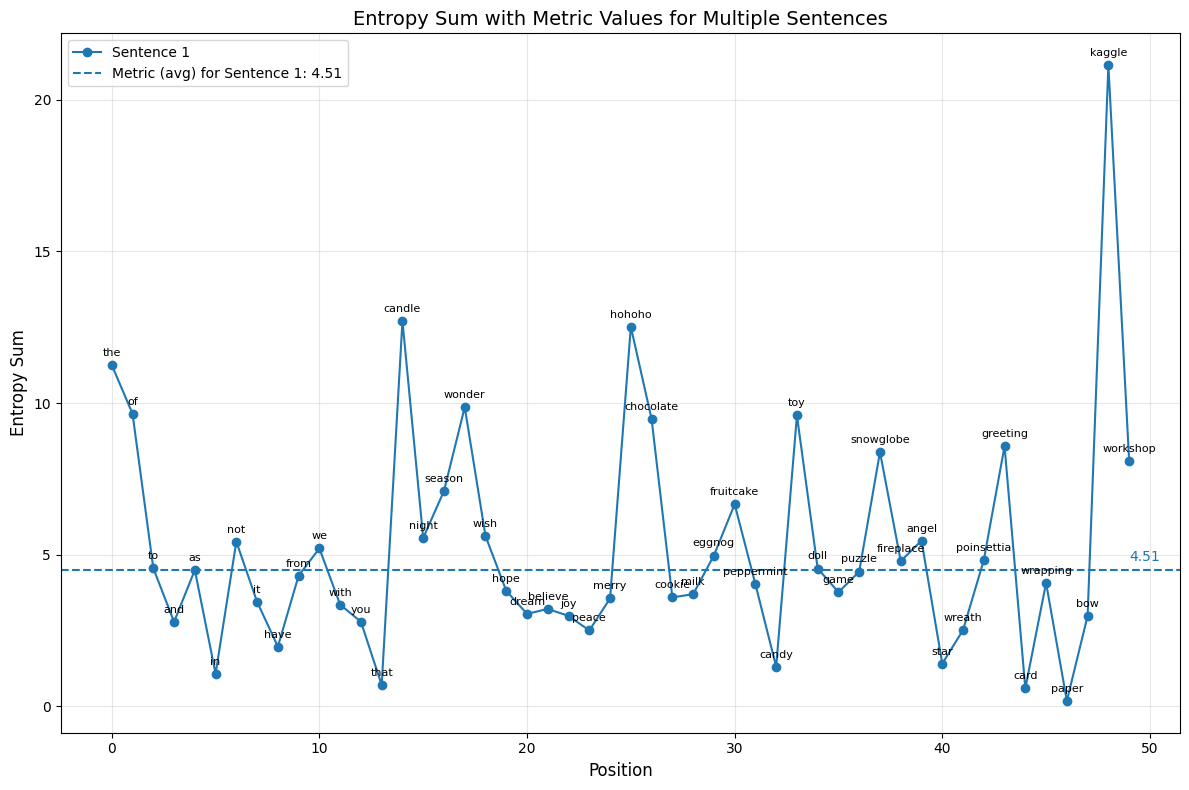

In [22]:

# Example sentences
sentences = [
  sentence,
]


# Initialize a figure for multiple subplots
plt.figure(figsize=(12, 8))

for idx, sentence in enumerate(sentences):
    # Mapping and entropy calculations
    entropy_values_batch, len_values_batch = calculator.get_batch_entropy_values([sentence])
    entropy_values = entropy_values_batch[0]
    len_value = len_values_batch[0]
    metric_value = np.sum(entropy_values) / len_value

    word_entropies = calculate_word_entropies(sentence, tokenizer, entropy_values)

    # Extract data for plotting
    positions = list(range(len(word_entropies)))  # Position indices
    entropy_values = [item['entropy_sum'] for item in word_entropies]  # Entropy values
    words = [item['word'] for item in word_entropies]  # Words

    # Plot the sentence line
    line, = plt.plot(positions, entropy_values, marker='o', linestyle='-', label=f'Sentence {idx + 1}')

    # Get the color of the line
    line_color = line.get_color()

    # Add words as text labels at each data point
    for i, word in enumerate(words):
        plt.text(positions[i], entropy_values[i] + 0.3, word, ha='center', fontsize=8)

    # Add metric value as a horizontal line with the same color
    plt.axhline(y=metric_value, color=line_color, linestyle='--', label=f'Metric (avg) for Sentence {idx + 1}: {metric_value:.2f}')

    # Annotate the metric value with the same color
    plt.text(len(positions) - 1, metric_value + 0.3, f'{metric_value:.2f}', color=line_color, fontsize=10)

# Customize the plot
plt.title('Entropy Sum with Metric Values for Multiple Sentences', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Entropy Sum', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# permute 2 words in one sentence

In [24]:
data.loc[4,'text']

'the of to and as in not it have from we with you that candle night season wonder wish hope dream believe joy peace merry hohoho chocolate cookie milk eggnog fruitcake peppermint candy toy doll game puzzle snowglobe fireplace angel star wreath poinsettia greeting card wrapping paper bow kaggle workshop'

In [25]:
sentence1= 'from and as have in not it of that the to we with you bow angel believe candle candy card chocolate cookie doll dream eggnog fireplace fruitcake game greeting hohoho hope joy kaggle merry milk night peace peppermint poinsettia puzzle season snowglobe star toy wreath wish workshop wonder wrapping paper'

sentence2= 'the of to and as in not it have from we with you that candle night season wonder wish hope dream believe joy peace merry hohoho chocolate cookie milk eggnog fruitcake peppermint candy toy doll game puzzle snowglobe fireplace angel star wreath poinsettia greeting card wrapping paper bow kaggle workshop'


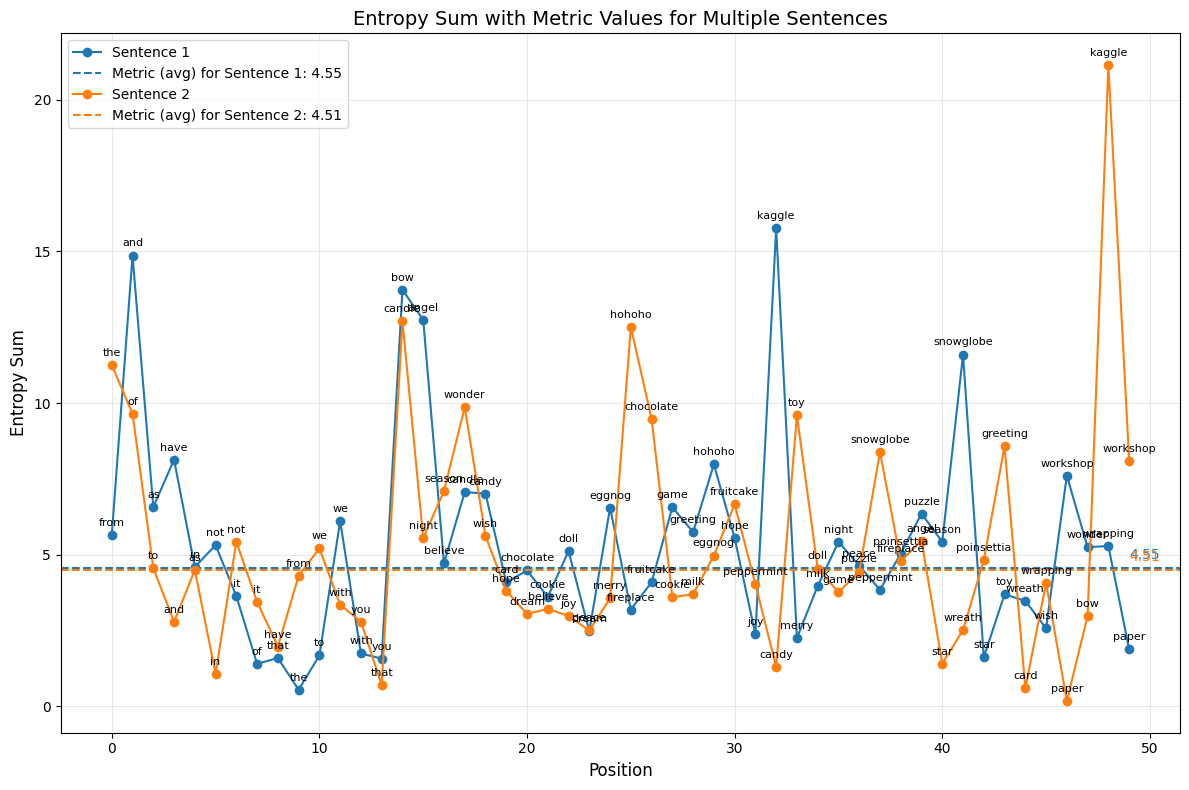

In [26]:

# Example sentences
sentences = [
sentence1,
sentence2
]


# Initialize a figure for multiple subplots
plt.figure(figsize=(12, 8))

for idx, sentence in enumerate(sentences):
    # Mapping and entropy calculations
    entropy_values_batch, len_values_batch = calculator.get_batch_entropy_values([sentence])
    entropy_values = entropy_values_batch[0]
    len_value = len_values_batch[0]
    metric_value = np.sum(entropy_values) / len_value

    word_entropies = calculate_word_entropies(sentence, tokenizer, entropy_values)

    # Extract data for plotting
    positions = list(range(len(word_entropies)))  # Position indices
    entropy_values = [item['entropy_sum'] for item in word_entropies]  # Entropy values
    words = [item['word'] for item in word_entropies]  # Words

    # Plot the sentence line
    line, = plt.plot(positions, entropy_values, marker='o', linestyle='-', label=f'Sentence {idx + 1}')

    # Get the color of the line
    line_color = line.get_color()

    # Add words as text labels at each data point
    for i, word in enumerate(words):
        plt.text(positions[i], entropy_values[i] + 0.3, word, ha='center', fontsize=8)

    # Add metric value as a horizontal line with the same color
    plt.axhline(y=metric_value, color=line_color, linestyle='--', label=f'Metric (avg) for Sentence {idx + 1}: {metric_value:.2f}')

    # Annotate the metric value with the same color
    plt.text(len(positions) - 1, metric_value + 0.3, f'{metric_value:.2f}', color=line_color, fontsize=10)

# Customize the plot
plt.title('Entropy Sum with Metric Values for Multiple Sentences', fontsize=14)
plt.xlabel('Position', fontsize=12)
plt.ylabel('Entropy Sum', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

# Visualization Per token value

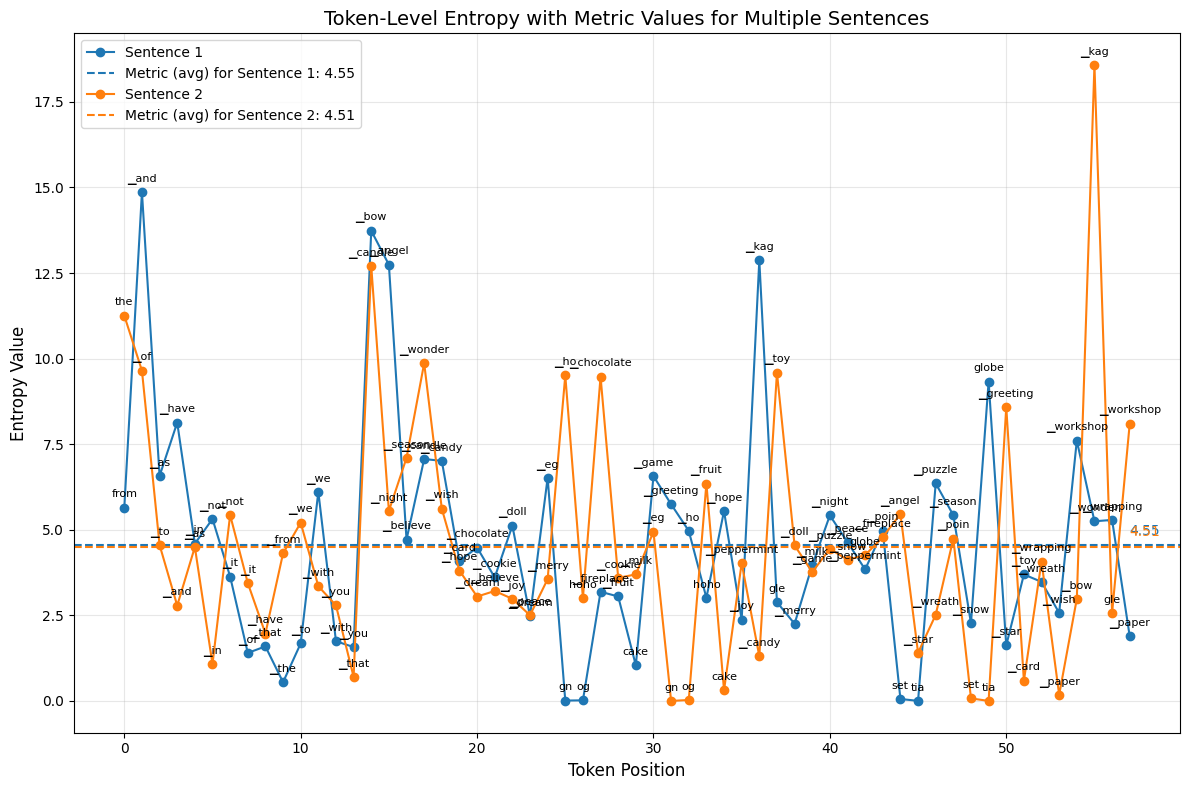

In [27]:
# Example sentences
sentences = [
    sentence1,
    sentence2
]

# Initialize a figure for multiple subplots
plt.figure(figsize=(12, 8))

for idx, sentence in enumerate(sentences):
    # Token-level entropy calculations
   
    entropy_values_batch, len_values_batch = calculator.get_batch_entropy_values([sentence])
    entropy_values = entropy_values_batch[0]  # Get entropy values
    len_value = len_values_batch[0]
    metric_value = np.sum(entropy_values) / len_value

    # Tokenization with special tokens
    model_inputs = tokenizer(f"{tokenizer.bos_token}{sentence}{tokenizer.eos_token}", return_tensors='pt')
    tokens = tokenizer.convert_ids_to_tokens(model_inputs['input_ids'][0])

    # Remove duplicate <BOS> tokens (if present) and adjust entropy values
    while tokens[0] == tokenizer.bos_token:  # Remove all <BOS> tokens at the start
        tokens.pop(0)

    #remove <eos>
    tokens = tokens[:-1]    
    entropy_values = entropy_values[:-1] 

    # Generate positions for tokens
    positions = list(range(len(tokens)))  # Ensure positions match token count

    # Plot the token entropy line
    line, = plt.plot(positions, entropy_values, marker='o', linestyle='-', label=f'Sentence {idx + 1}')

    # Get the color of the line
    line_color = line.get_color()

    # Add tokens as text labels at each data point
    for i, token in enumerate(tokens):
        plt.text(positions[i], entropy_values[i] + 0.3, token, ha='center', fontsize=8)

    # Add metric value as a horizontal line with the same color
    plt.axhline(y=metric_value, color=line_color, linestyle='--', label=f'Metric (avg) for Sentence {idx + 1}: {metric_value:.2f}')

    # Annotate the metric value with the same color
    plt.text(len(positions) - 1, metric_value + 0.3, f'{metric_value:.2f}', color=line_color, fontsize=10)

# Customize the plot
plt.title('Token-Level Entropy with Metric Values for Multiple Sentences', fontsize=14)
plt.xlabel('Token Position', fontsize=12)
plt.ylabel('Entropy Value', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


# Visualization for all sentences in dataset

In [34]:

# Example sentences
def visualize_sentence(sentence, title = ''):
    sentences = [
      sentence
    
    ]
    
    
    # Initialize a figure for multiple subplots
    plt.figure(figsize=(8, 4))
    
    for idx, sentence in enumerate(sentences):
        # Mapping and entropy calculations
        entropy_values_batch, len_values_batch = calculator.get_batch_entropy_values([sentence])
        entropy_values = entropy_values_batch[0]
        len_value = len_values_batch[0]
        metric_value = np.sum(entropy_values) / len_value
    
        word_entropies = calculate_word_entropies(sentence, tokenizer, entropy_values)
    
        # Extract data for plotting
        positions = list(range(len(word_entropies)))  # Position indices
        entropy_values = [item['entropy_sum'] for item in word_entropies]  # Entropy values
        words = [item['word'] for item in word_entropies]  # Words
    
        # Plot the sentence line
        line, = plt.plot(positions, entropy_values, marker='o', linestyle='-', label=f'Sentence {idx + 1}')
    
        # Get the color of the line
        line_color = line.get_color()
    
        # Add words as text labels at each data point
        for i, word in enumerate(words):
            plt.text(positions[i], entropy_values[i] + 0.3, word, ha='center', fontsize=8)
    
        # Add metric value as a horizontal line with the same color
        plt.axhline(y=metric_value, color=line_color, linestyle='--', label=f'Metric (avg) for Sentence {idx + 1}: {metric_value:.2f}')
    
        # Annotate the metric value with the same color
        plt.text(len(positions) - 1, metric_value + 0.3, f'{metric_value:.2f}', color=line_color, fontsize=10)
    
    # Customize the plot
    plt.title(f'Entropy Sum with Metric Values for Sentence {title}', fontsize=14)
    plt.xlabel('Position', fontsize=12)
    plt.ylabel('Entropy Sum', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()
    # plt.tight_layout()
    
    # Show the plot
    plt.show()
    # print("\n")

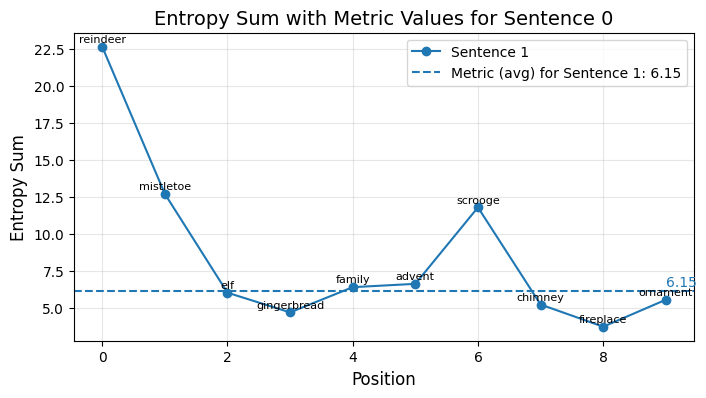

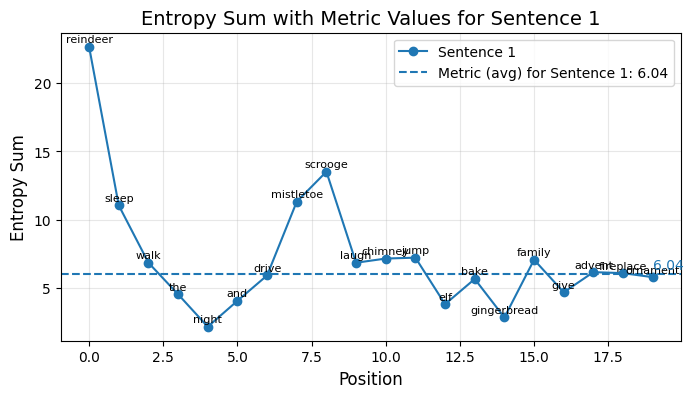

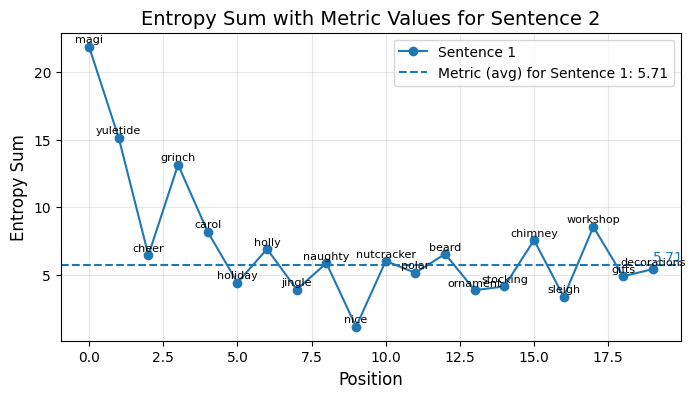

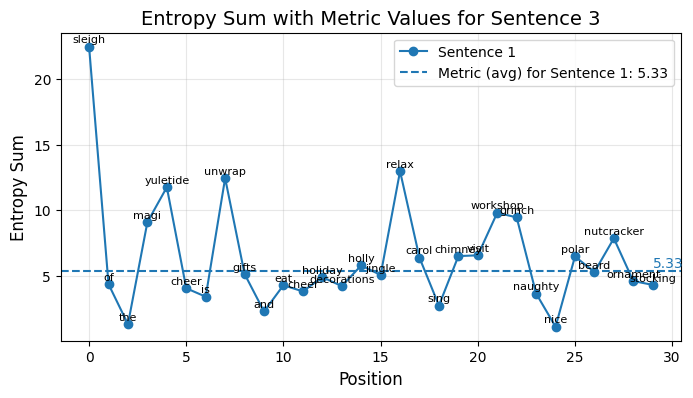

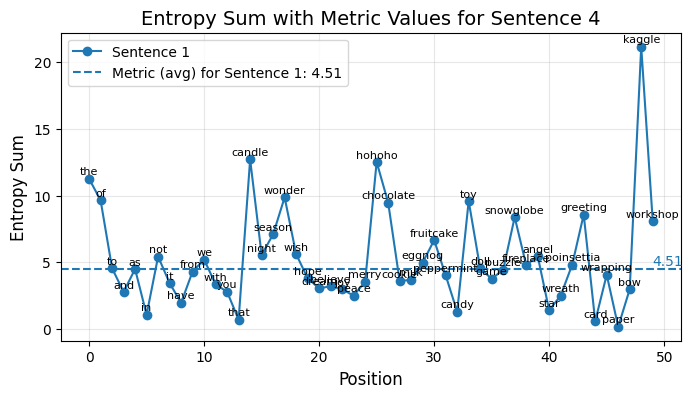

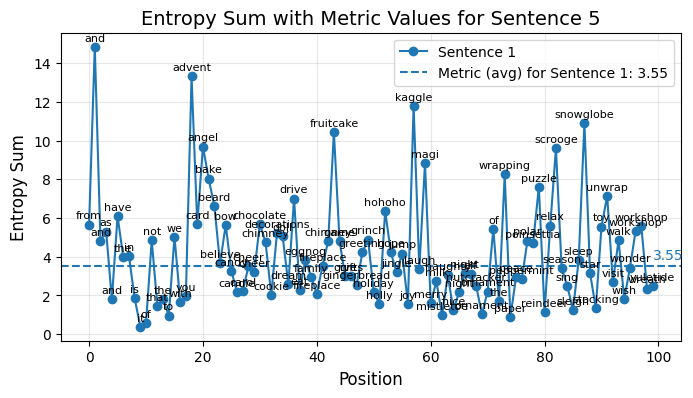

In [35]:
for i, sentence in enumerate(data['text']):
    visualize_sentence(sentence, title = i)

In [30]:
data

,id,text,score
0,0,reindeer mistletoe elf gingerbread family adve...,468.961335
1,1,reindeer sleep walk the night and drive mistle...,421.728839
2,2,magi yuletide cheer grinch carol holiday holly...,302.640572
3,3,sleigh of the magi yuletide cheer is unwrap gi...,207.080571
4,4,the of to and as in not it have from we with y...,90.810875
5,5,from and and as and have the in is it of not t...,34.643570
